In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import display
from tab_hero.dataio.tokenizer import ChartTokenizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score
from itertools import product
from scipy.stats import spearmanr

import random

In [2]:
project_root = Path.cwd()
sys.path.insert(0, str(project_root / "src"))

from tab_hero.dataio.tab_format import load_tab
data_dir = Path("../data/processed") 
tab_files = list(data_dir.glob("*.tab"))
SEED = 42

In [3]:
features_path = Path("../features.csv")

df_features = pd.read_csv(features_path)
df_features.head()


,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,...,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,00068c50bf7a2a95,0,2,7,3631,163.480091,1.891090,1.430148,0.402069,4.052784,...,742.686223,830.0,820.0,830.0,0.041667,0.000000,1.107923,0.000000,0.104167,0.000000
1,00044d42d97be12d,0,2,4,1694,194.292971,1.687803,0.795066,0.098820,2.682918,...,564.478392,1060.0,1050.0,1085.0,0.378378,0.000000,0.986289,0.000000,0.189189,0.000000
2,0005aa02866dddf6,0,2,1,2663,313.620317,1.692548,0.409827,0.087721,2.114662,...,473.929208,730.0,720.0,740.0,0.075269,0.000000,1.488865,0.997312,0.169355,0.000000
3,0003cad26b028e39,1,0,1,1470,285.826032,1.766457,0.513506,0.056087,2.944388,...,415.654713,360.0,240.0,490.0,0.356021,0.031414,1.367438,0.942408,0.116928,0.057592
4,0005cc1d3cbc5253,2,1,3,340,247.118367,3.104284,1.243821,0.271522,6.126035,...,580.585199,250.0,250.0,510.0,0.111905,0.690476,1.583723,0.990476,0.119048,0.002381


In [4]:
tab_files = sorted(tab_files)
random.seed(SEED)
sample_files = random.sample(tab_files, k=300)

In [5]:
rows = []
errors = []

for p in sample_files:
    try:
        data = load_tab(p)
        row = dict(data.__dict__)
        rows.append(row)
    except Exception as e:
        
        errors.append((p.name, str(e)))


In [6]:
df_tabs = pd.DataFrame(rows)
df_tabs.head()

,mel_spectrogram,sample_rate,hop_length,note_tokens,difficulty_id,instrument_id,content_hash,genre_id,song_id
0,"[[-1.1279297, -1.1279297, -1.1279297, -1.12792...",22050,256,"[1, 503, 518, 631, 642, 70, 518, 631, 642, 70,...",2,0,c940117355a8f420,1,6052
1,"[[-2.8808594, -2.9042969, -3.0117188, -3.13281...",22050,256,"[1, 503, 505, 631, 640, 35, 505, 631, 640, 35,...",2,0,237b10b35cabd811,1,472
2,"[[-2.2167969, -2.2167969, -2.2167969, -2.21679...",22050,256,"[1, 440, 504, 631, 642, 36, 505, 631, 642, 36,...",2,0,07e1e41e1003f1b1,13,5934
3,"[[-2.6796875, -2.6796875, -2.6796875, -2.67968...",22050,256,"[1, 503, 504, 632, 653, 77, 504, 632, 639, 40,...",1,2,e924eea23ea77a15,7,370
4,"[[-2.6230469, -2.6230469, -2.6230469, -2.62304...",22050,256,"[1, 393, 504, 631, 642, 84, 505, 631, 642, 51,...",1,2,563cfff61d1a085a,1,3592


<h1>1. Difficulty analysis </h1>

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\2415312541.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


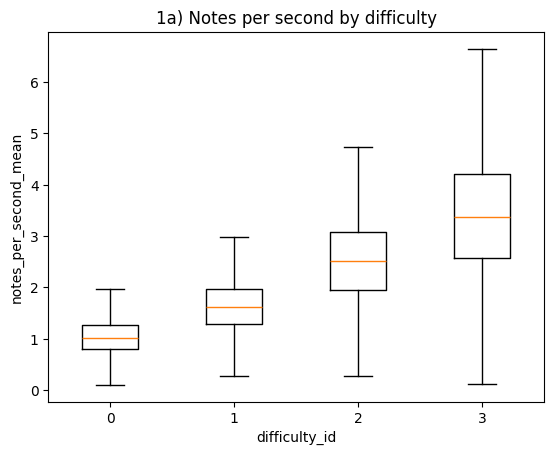

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\2415312541.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


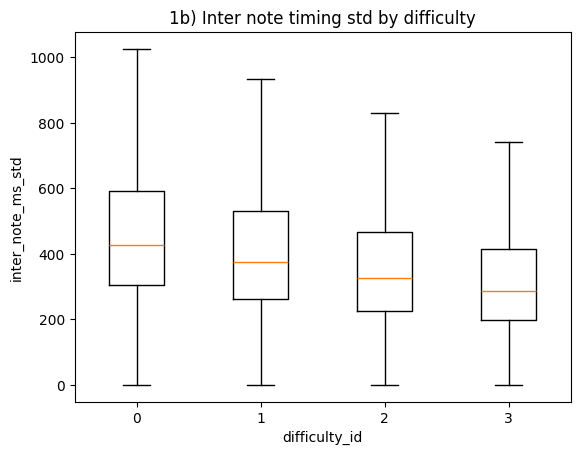

In [7]:
def plot_box_by_difficulty(df, y_col, title):
    diffs = sorted(df["difficulty_id"].dropna().unique())
    groups = [df.loc[df["difficulty_id"] == d, y_col].dropna() for d in diffs]
    plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)
    plt.xlabel("difficulty_id")
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()


plot_box_by_difficulty(df_features, "notes_per_second_mean", "1a) Notes per second by difficulty")
plot_box_by_difficulty(df_features, "inter_note_ms_std", "1b) Inter note timing std by difficulty")


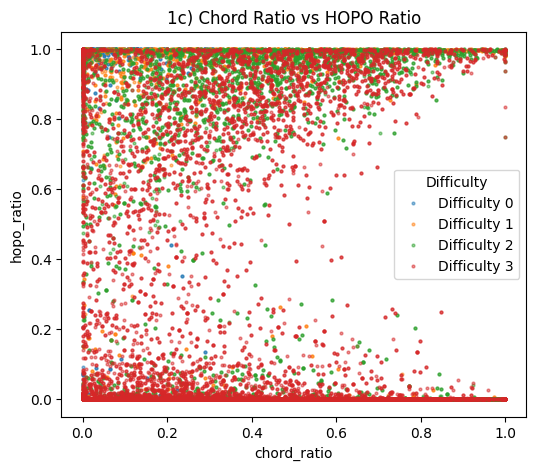

In [8]:
difficulty_levels = sorted(df_features["difficulty_id"].dropna().unique())

plt.figure(figsize=(6, 5))

for d in difficulty_levels:
    mask = (
        df_features["chord_ratio"].notna() &
        df_features["hopo_ratio"].notna() &
        (df_features["difficulty_id"] == d)
    )

    plt.scatter(
        df_features.loc[mask, "chord_ratio"],
        df_features.loc[mask, "hopo_ratio"],
        s=4,
        alpha=0.5,
        label=f"Difficulty {d}"
    )

plt.xlabel("chord_ratio")
plt.ylabel("hopo_ratio")
plt.title("1c) Chord Ratio vs HOPO Ratio")
plt.legend(title="Difficulty")
plt.show()

<h1>2. Instrument Analysis</h1>

In [9]:
instrument_names = {
    0: "Lead",
    1: "Bass",
    2: "Rythm",
    3: "Keys",
}

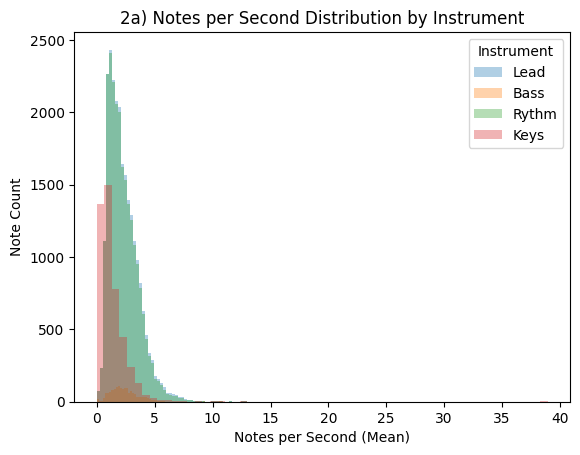

In [10]:
insts = sorted(df_features["instrument_id"].dropna().unique())

for inst in insts:
    vals = df_features.loc[
        df_features["instrument_id"] == inst,
        "notes_per_second_mean"
    ].dropna()

    plt.hist(
        vals,
        bins=60,
        alpha=0.35,
        label=instrument_names.get(inst, str(inst))
    )

plt.xlabel("Notes per Second (Mean)")
plt.ylabel("Note Count")
plt.title("2a) Notes per Second Distribution by Instrument")
plt.legend(title="Instrument")
plt.show()

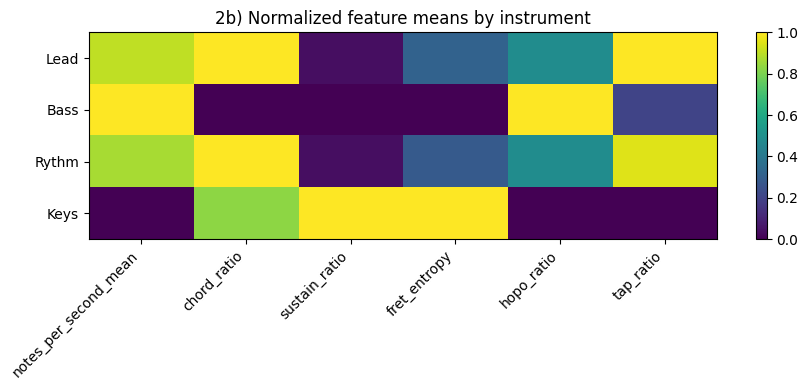

In [11]:
cols = ["notes_per_second_mean", "chord_ratio", "sustain_ratio", "fret_entropy", "hopo_ratio", "tap_ratio"]
means = df_features.groupby("instrument_id")[cols].mean().sort_index()
norm = (means - means.min()) / (means.max() - means.min())



plt.figure(figsize=(9, 4))
plt.imshow(norm.values, aspect="auto")

plt.yticks(
    range(len(norm.index)),
    [instrument_names.get(i, str(i)) for i in norm.index]
)

plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.colorbar()
plt.title("2b) Normalized feature means by instrument")
plt.tight_layout()
plt.show()

<h1>3. Density Profiling</h1>

In [12]:
def time_bins_from_tokens(tokens, tokenizer):
    toks = np.array(tokens, dtype=np.int32)
    time_mask = (toks >= tokenizer._time_token_start) & (toks < tokenizer._time_token_end)
    return (toks[time_mask] - tokenizer._time_token_start).astype(np.int32)

def rolling_density(time_bins, window=80):
    if len(time_bins) == 0:
        return np.array([])
    inv = 1.0 / np.clip(np.array(time_bins, dtype=np.float32), 1e-6, None)
    if inv.size < window:
        window = inv.size
    return np.convolve(inv, np.ones(window) / window, mode="valid")


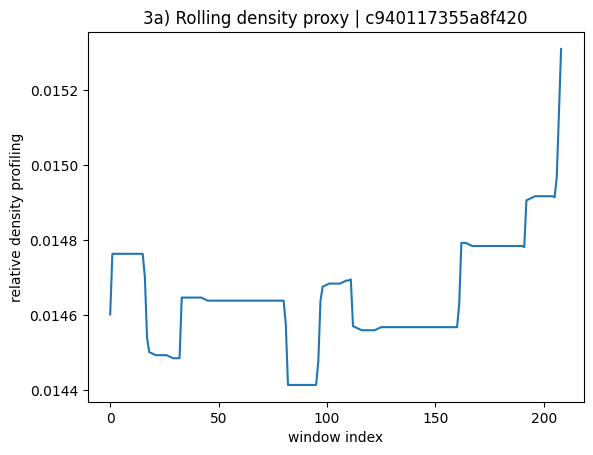

In [13]:
tokenizer = ChartTokenizer()

r = df_tabs.iloc[0]
tb = time_bins_from_tokens(r["note_tokens"], tokenizer)
rd = rolling_density(tb, window=80)

plt.plot(rd)
plt.xlabel("window index")
plt.ylabel("relative density profiling")
plt.title(f"3a) Rolling density proxy | {r.get('content_hash','')}")
plt.show()

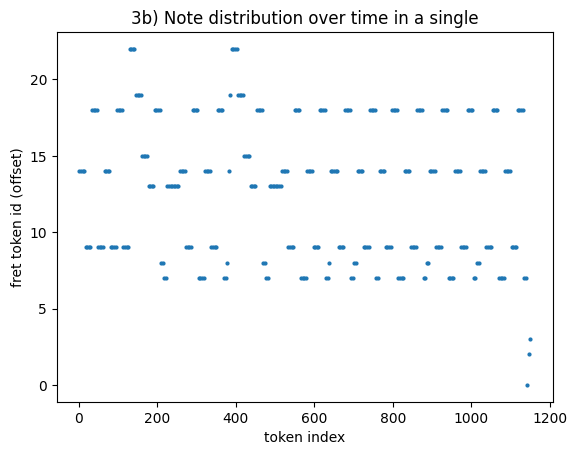

In [14]:
r = df_tabs.iloc[0]
toks = np.array(r["note_tokens"], dtype=np.int32)

fret_mask = (toks >= tokenizer._fret_token_start) & (toks < tokenizer._fret_token_end)
fret_positions = np.where(fret_mask)[0]
fret_ids = toks[fret_mask] - tokenizer._fret_token_start

plt.scatter(fret_positions, fret_ids, s=4)
plt.xlabel("token index")
plt.ylabel("fret token id (offset)")
plt.title("3b) Note distribution over time in a single")
plt.show()

<h1>4. Feature Reduction</h1>

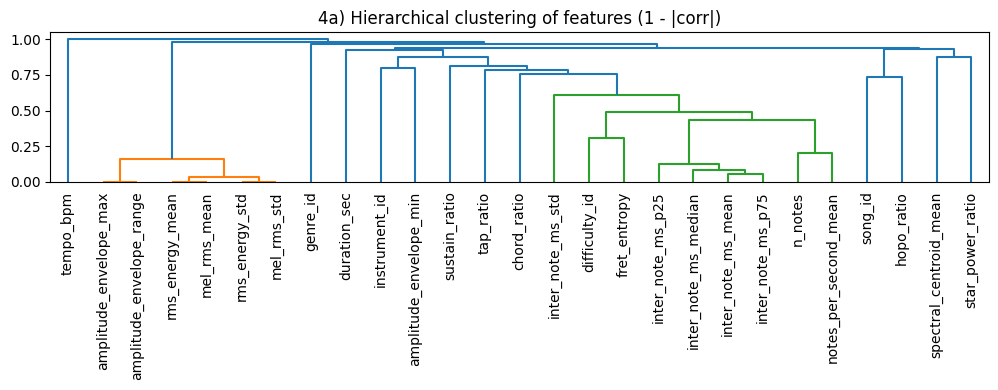

In [15]:
num_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
corr = df_features[num_cols].corr().fillna(0.0)

dist = 1 - corr.abs()
dist_condensed = squareform(dist.values, checks=False)
Z = linkage(dist_condensed, method="average")

plt.figure(figsize=(10, 4))
dendrogram(Z, labels=num_cols, leaf_rotation=90)
plt.title("4a) Hierarchical clustering of features (1 - |corr|)")
plt.tight_layout()
plt.show()

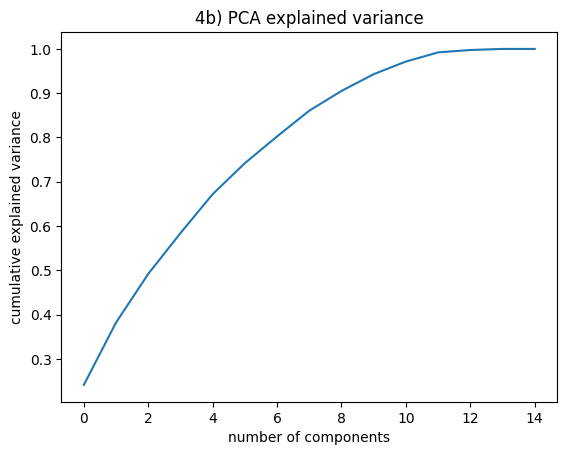

,PC1,PC2
notes_per_second_mean,0.488534,0.032813
inter_note_ms_mean,0.462060,0.000930
n_notes,0.440975,0.063888
inter_note_ms_std,0.363520,0.050894
fret_entropy,0.304287,0.077253
tap_ratio,0.218841,0.048142
sustain_ratio,0.198939,0.034073
chord_ratio,0.165399,0.006378
duration_sec,0.065548,0.083390
hopo_ratio,0.053997,0.004001


,PC1,PC2
mel_rms_std,0.039000,0.697345
mel_rms_mean,0.041907,0.697299
duration_sec,0.065548,0.083390
fret_entropy,0.304287,0.077253
n_notes,0.440975,0.063888
inter_note_ms_std,0.363520,0.050894
tap_ratio,0.218841,0.048142
star_power_ratio,0.040265,0.043992
spectral_centroid_mean,0.041261,0.036636
sustain_ratio,0.198939,0.034073


In [16]:
use_cols = [
    "duration_sec", "tempo_bpm", "n_notes", "notes_per_second_mean",
    "inter_note_ms_mean", "inter_note_ms_std", "sustain_ratio", "chord_ratio",
    "fret_entropy", "hopo_ratio", "tap_ratio", "star_power_ratio",
    "mel_rms_mean", "mel_rms_std", "spectral_centroid_mean"
]
X = df_features[use_cols].replace([np.inf, -np.inf], np.nan).dropna()
scaled = StandardScaler().fit_transform(X.values)
pca = PCA().fit(scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("4b) PCA explained variance")
plt.show()

loadings = pd.DataFrame(pca.components_[:2], columns=use_cols, index=["PC1", "PC2"]).T
display(loadings.abs().sort_values("PC1", ascending=False).head(10))
display(loadings.abs().sort_values("PC2", ascending=False).head(10))


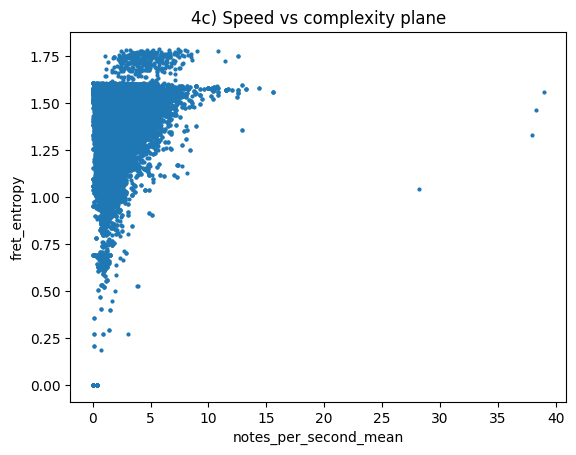

In [17]:
speed = df_features["notes_per_second_mean"]
complexity = df_features["fret_entropy"]
s = df_features[["notes_per_second_mean", "fret_entropy"]].dropna()
plt.scatter(s["notes_per_second_mean"], s["fret_entropy"], s=4)
plt.xlabel("notes_per_second_mean")
plt.ylabel("fret_entropy")
plt.title("4c) Speed vs complexity plane")
plt.show()

<h1>5. Extreme Value and Structure Discovery</h1>

In [18]:
out = df_features.copy()
out["is_top_density"] = out["notes_per_second_mean"] >= out["notes_per_second_mean"].quantile(0.99)
ct = pd.crosstab(out["instrument_id"], out["is_top_density"])
display(ct)

is_top_density,False,True
instrument_id,,
0,23641,276
1,1491,11
2,23165,222
3,4552,25


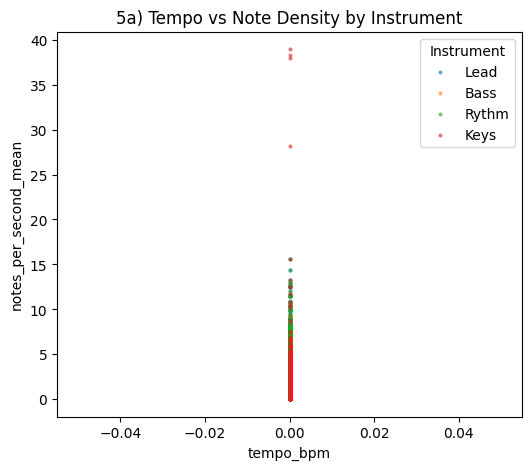

In [19]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["tempo_bpm"].notna() &
        df_features["notes_per_second_mean"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "tempo_bpm"],
        df_features.loc[mask, "notes_per_second_mean"],
        s=4,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("tempo_bpm")
plt.ylabel("notes_per_second_mean")
plt.title("5a) Tempo vs Note Density by Instrument")
plt.legend(title="Instrument")
plt.show()

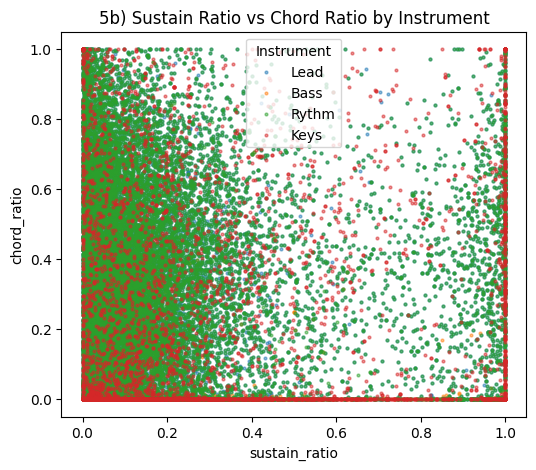

In [20]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["sustain_ratio"].notna() &
        df_features["chord_ratio"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "sustain_ratio"],
        df_features.loc[mask, "chord_ratio"],
        s=4,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("sustain_ratio")
plt.ylabel("chord_ratio")
plt.title("5b) Sustain Ratio vs Chord Ratio by Instrument")
plt.legend(title="Instrument")
plt.show()


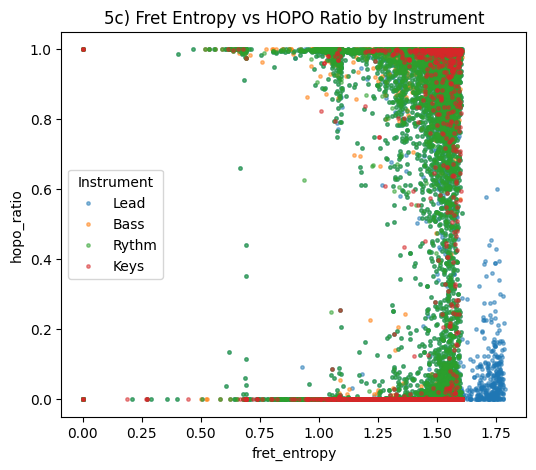

In [21]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["fret_entropy"].notna() &
        df_features["hopo_ratio"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "fret_entropy"],
        df_features.loc[mask, "hopo_ratio"],
        s=6,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("fret_entropy")
plt.ylabel("hopo_ratio")
plt.title("5c) Fret Entropy vs HOPO Ratio by Instrument")
plt.legend(title="Instrument")
plt.show()


###### <h1>6. Data Distribution Analysis</h1>

difficulty_id,0,1,2,3
instrument_id,,,,
0,5841,5837,5841,6398
1,373,374,372,383
2,5786,5780,5784,6037
3,1138,1139,1141,1159


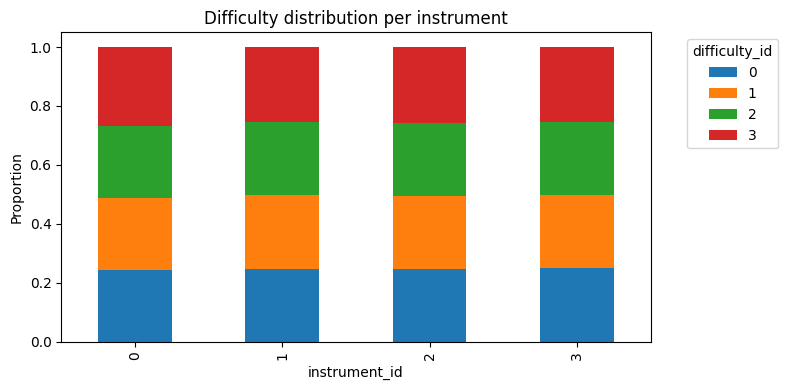

In [22]:
ct = pd.crosstab(df_features["instrument_id"], df_features["difficulty_id"])
display(ct)

ct_norm = ct.div(ct.sum(axis=1), axis=0)
ct_norm.plot(kind="bar", stacked=True, figsize=(8, 4))
plt.ylabel("Proportion")
plt.title("Difficulty distribution per instrument")
plt.legend(title="difficulty_id", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\2415312541.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


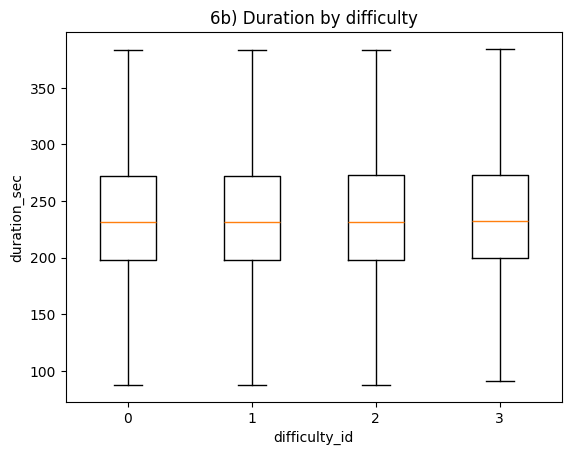

In [23]:
plot_box_by_difficulty(df_features, "duration_sec", "6b) Duration by difficulty")

8c) fraction chord-dominated charts (chord_ratio > 0.5): 0.2382406384054849


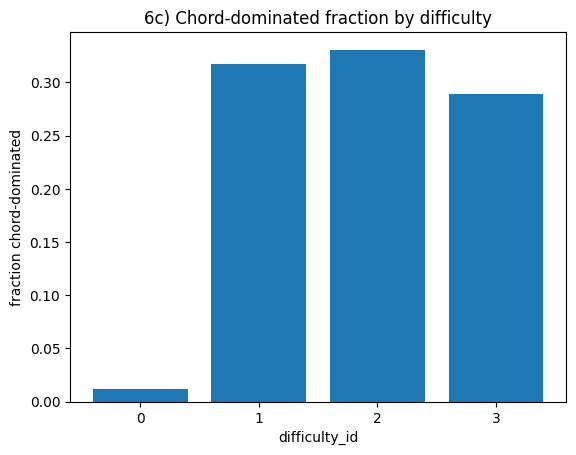

In [24]:
frac_by_diff = df_features.assign(chord_dominated=df_features["chord_ratio"] > 0.5) \
                              .groupby("difficulty_id")["chord_dominated"].mean().sort_index()
plt.bar(frac_by_diff.index.astype(str), frac_by_diff.values)
plt.xlabel("difficulty_id")
plt.ylabel("fraction chord-dominated")
plt.title("6c) Chord-dominated fraction by difficulty")
plt.show()


<h1>7. Cluster Analysis</h1>

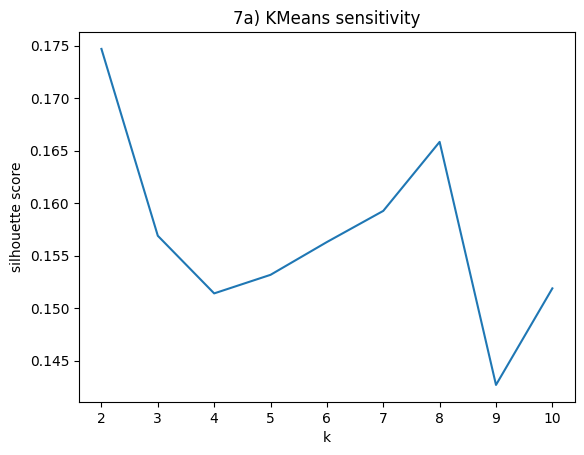

In [25]:
X = df_features[use_cols].replace([np.inf, -np.inf], np.nan).dropna()
scaled = StandardScaler().fit_transform(X.values)

ks = range(2, 11)
sil = []
for k in ks:
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(scaled)
    sil.append(silhouette_score(scaled, labels))

plt.plot(list(ks), sil)
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.title("7a) KMeans sensitivity")
plt.show()

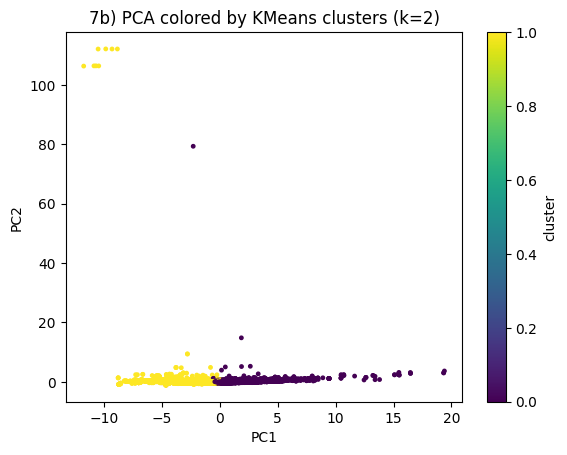

         duration_sec  tempo_bpm     n_notes  notes_per_second_mean  \
cluster                                                               
0          243.702495        0.0  738.999028               3.017241   
1          243.672664        0.0  279.273550               1.157693   

         inter_note_ms_mean  inter_note_ms_std  sustain_ratio  chord_ratio  \
cluster                                                                      
0                339.118840         291.688263       0.153817     0.395111   
1                867.084419         534.817225       0.273634     0.155579   

         fret_entropy  hopo_ratio  tap_ratio  star_power_ratio  mel_rms_mean  \
cluster                                                                        
0            1.467656    0.264437   0.046328          0.175564      1.784298   
1            1.252063    0.199261   0.005034          0.191718      2.097338   

         mel_rms_std  spectral_centroid_mean  
cluster                           

In [26]:
best_k = int(list(ks)[int(np.argmax(sil))])
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(scaled)

    
Z = PCA(n_components=2, random_state=0).fit_transform(scaled)
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"7b) PCA colored by KMeans clusters (k={best_k})")
plt.colorbar(label="cluster")
plt.show()

centroid = pd.DataFrame(X.values, columns=use_cols).assign(cluster=labels).groupby("cluster")[use_cols].mean()
print(centroid)

In [27]:
X = df_features[use_cols].replace([np.inf, -np.inf], np.nan).dropna()
scaled = StandardScaler().fit_transform(X.values)
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(scaled)

tmp = df_features.loc[X.index, ["difficulty_id"]].copy()
tmp["cluster"] = labels
ct = pd.crosstab(tmp["cluster"], tmp["difficulty_id"])
print(ct)


difficulty_id      0     1      2      3
cluster                                 
0                186  6108  10879  12675
1              12952  7022   2259   1302


<h1>8. Difficulty Ambiguity and Overlap Analysis </h1>

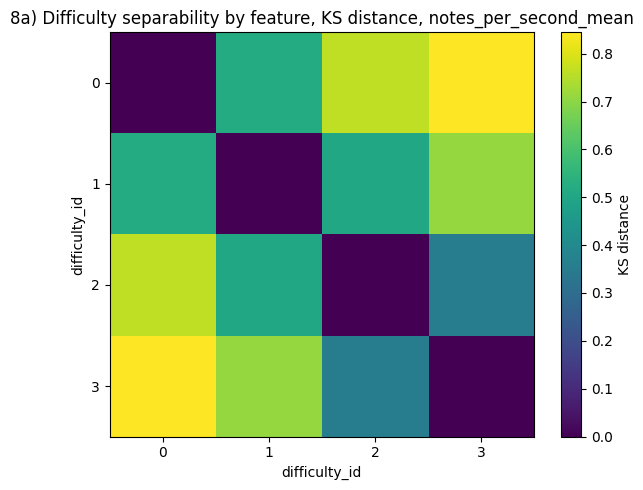

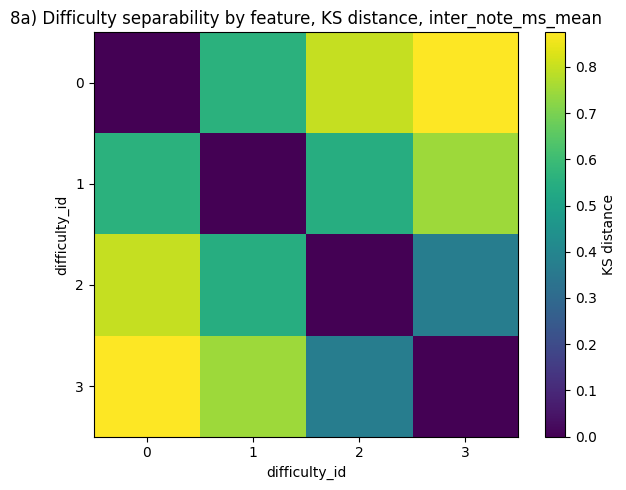

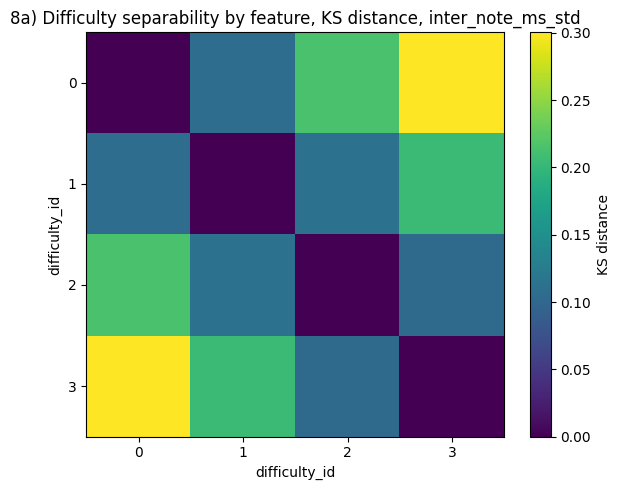

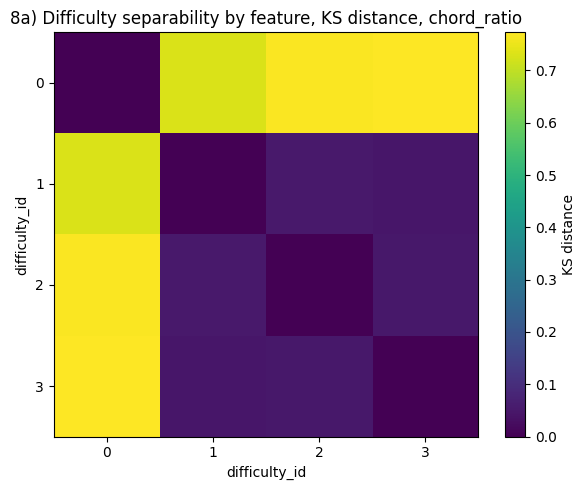

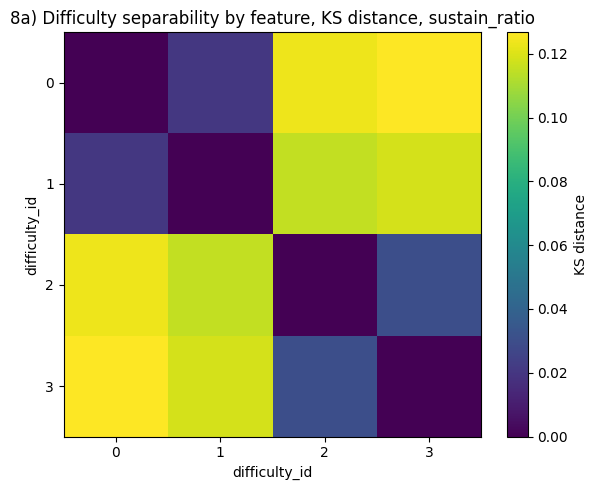

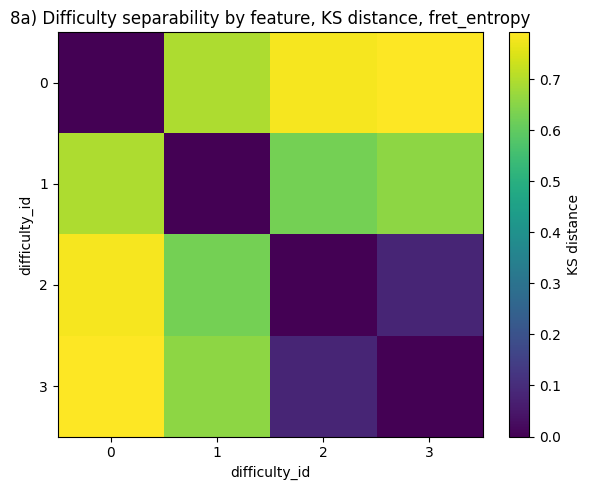

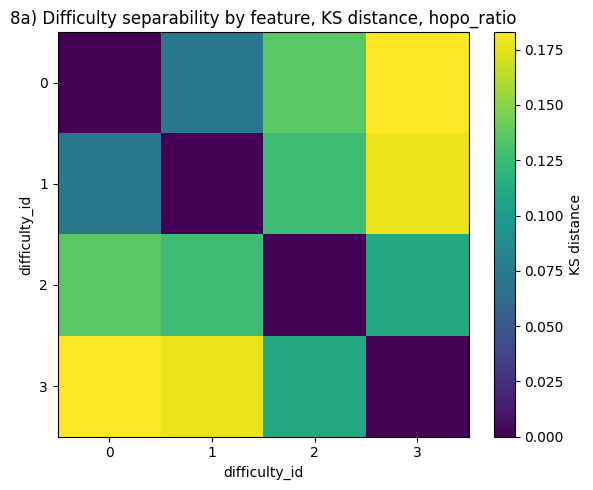

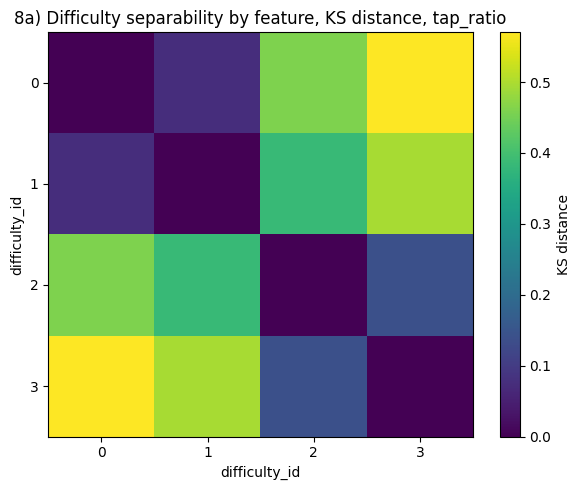

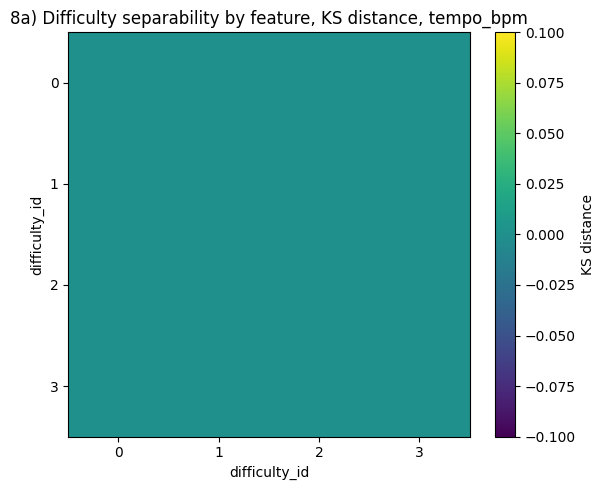

In [28]:
key_features = [
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "inter_note_ms_std",
    "chord_ratio",
    "sustain_ratio",
    "fret_entropy",
    "hopo_ratio",
    "tap_ratio",
    "tempo_bpm",
]

diffs = sorted(df_features["difficulty_id"].dropna().unique())

def ks_statistic(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 5 or len(b) < 5:
        return np.nan
    a = np.sort(a)
    b = np.sort(b)

    
    x = np.sort(np.unique(np.concatenate([a, b])))
    cdf_a = np.searchsorted(a, x, side="right") / len(a)
    cdf_b = np.searchsorted(b, x, side="right") / len(b)
    return float(np.max(np.abs(cdf_a - cdf_b)))

for feat in key_features:
    M = np.zeros((len(diffs), len(diffs)), dtype=float)
    for i, di in enumerate(diffs):
        ai = df_features.loc[df_features["difficulty_id"] == di, feat].dropna()
        for j, dj in enumerate(diffs):
            bj = df_features.loc[df_features["difficulty_id"] == dj, feat].dropna()
            M[i, j] = ks_statistic(ai, bj)

    plt.figure(figsize=(6, 5))
    plt.imshow(M, aspect="auto")
    plt.xticks(range(len(diffs)), [str(d) for d in diffs])
    plt.yticks(range(len(diffs)), [str(d) for d in diffs])
    plt.colorbar(label="KS distance")
    plt.title(f"8a) Difficulty separability by feature, KS distance, {feat}")
    plt.xlabel("difficulty_id")
    plt.ylabel("difficulty_id")
    plt.tight_layout()
    plt.show()


In [29]:

use_cols = [
    "duration_sec","tempo_bpm","n_notes","notes_per_second_mean",
    "inter_note_ms_mean","inter_note_ms_std",
    "sustain_ratio","chord_ratio","fret_entropy",
    "hopo_ratio","tap_ratio","star_power_ratio",
    "mel_rms_mean","mel_rms_std","spectral_centroid_mean"
]

D = df_features[["difficulty_id"] + use_cols].replace([np.inf, -np.inf], np.nan).dropna()
X = D[use_cols].values
y = D["difficulty_id"].values

scaled = StandardScaler().fit_transform(X)

nn = NearestNeighbors(n_neighbors=6).fit(scaled)
dist, idx = nn.kneighbors(scaled)

nearest_other_is_adjacent = []
for r in range(len(scaled)):
    my = y[r]
    neighbors = idx[r, 1:]
    other = [y[k] for k in neighbors if y[k] != my]
    if len(other) == 0:
        nearest_other_is_adjacent.append(np.nan)
        continue
    nearest_other = other[0]
    nearest_other_is_adjacent.append(int(abs(nearest_other - my) == 1))

rate = np.nanmean(nearest_other_is_adjacent)
print("Fraction of points whose nearest different difficulty is adjacent:", float(rate))


Fraction of points whose nearest different difficulty is adjacent: 0.9563615982064216


<h1>9. Play Styles Within the Same Label</h1>

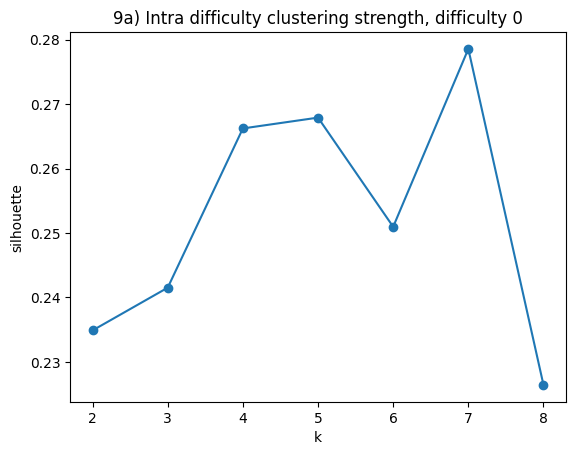

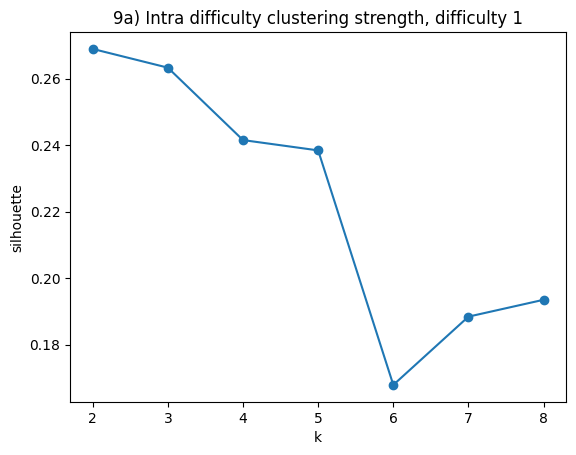

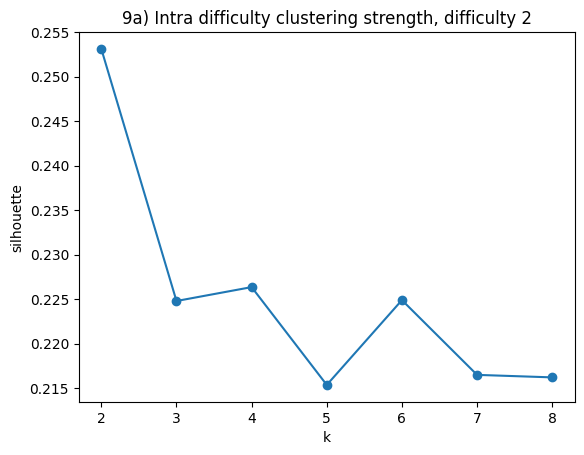

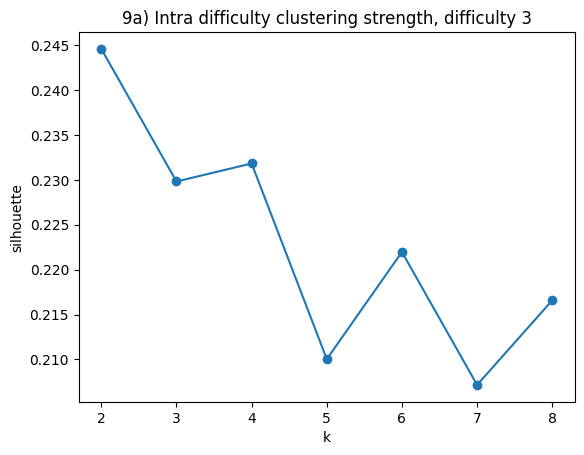

In [30]:

use_cols = [
    "tempo_bpm","notes_per_second_mean","inter_note_ms_mean","inter_note_ms_std",
    "chord_ratio","sustain_ratio","fret_entropy","hopo_ratio","tap_ratio",
    "mel_rms_mean","spectral_centroid_mean"
]

D = df_features[["difficulty_id"] + use_cols].replace([np.inf, -np.inf], np.nan).dropna()

for d in sorted(D["difficulty_id"].unique()):
    sub = D[D["difficulty_id"] == d]
    if len(sub) < 200:
        continue

    X = sub[use_cols].values
    scaled = StandardScaler().fit_transform(X)

    ks = range(2, 9)
    sil = []
    for k in ks:
        labels = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(scaled)
        sil.append(silhouette_score(scaled, labels))

    plt.plot(list(ks), sil, marker="o")
    
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.title(f"9a) Intra difficulty clustering strength, difficulty {d}")
    plt.show()


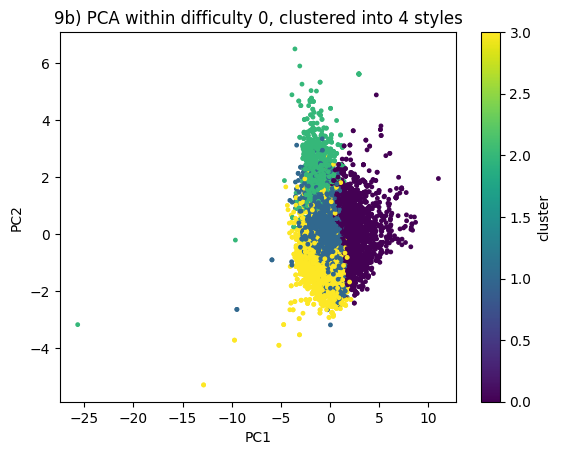

Cluster centroids within this difficulty
         tempo_bpm  notes_per_second_mean  inter_note_ms_mean  inter_note_ms_std  chord_ratio  sustain_ratio  fret_entropy  hopo_ratio  tap_ratio  mel_rms_mean  spectral_centroid_mean
cluster                                                                                                                                                                                
0              0.0                 0.6393           1396.2155           730.3216       0.0031         0.6077        1.2307      0.0395     0.0010        2.4847                 53.7451
1              0.0                 1.1427            853.8682           399.6663       0.0068         0.1097        1.1327      0.0004     0.0004        1.7750                 52.4351
2              0.0                 1.2748            765.2270           447.3069       0.3716         0.1042        1.0406      0.0779     0.0006        1.8473                 48.9501
3              0.0                 1.21

In [31]:

target_difficulty = sorted(D["difficulty_id"].unique())[0]
sub = D[D["difficulty_id"] == target_difficulty]

X = sub[use_cols].values
scaled = StandardScaler().fit_transform(X)

k = 4
labels = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(scaled)

Z = PCA(n_components=2, random_state=0).fit_transform(scaled)
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"9b) PCA within difficulty {target_difficulty}, clustered into {k} styles")
plt.colorbar(label="cluster")
plt.show()

centroids = sub.assign(cluster=labels).groupby("cluster")[use_cols].mean()
print("Cluster centroids within this difficulty")
print(centroids.round(4).to_string())


# <h1>10. Instrument conditioned difficulty drift </h1>

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\3475120436.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


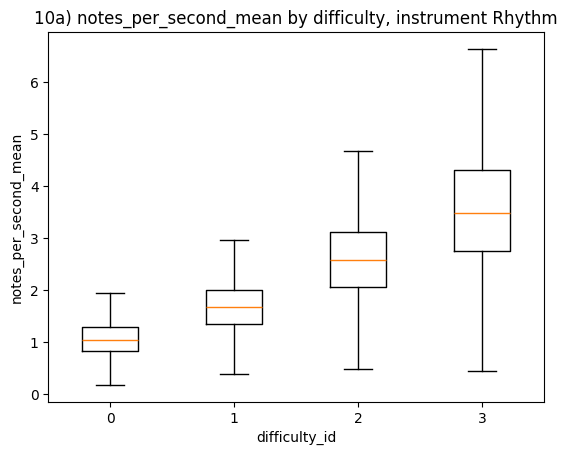

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\3475120436.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


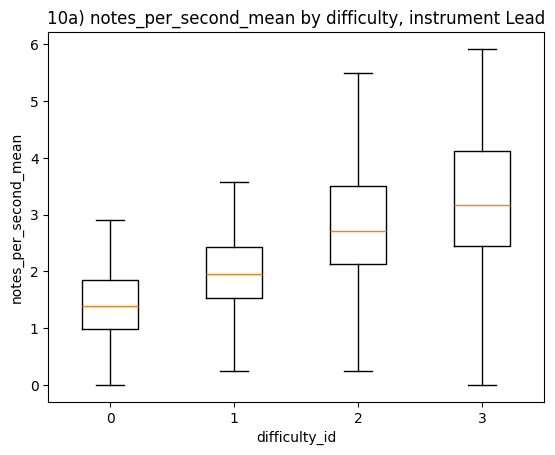

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\3475120436.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


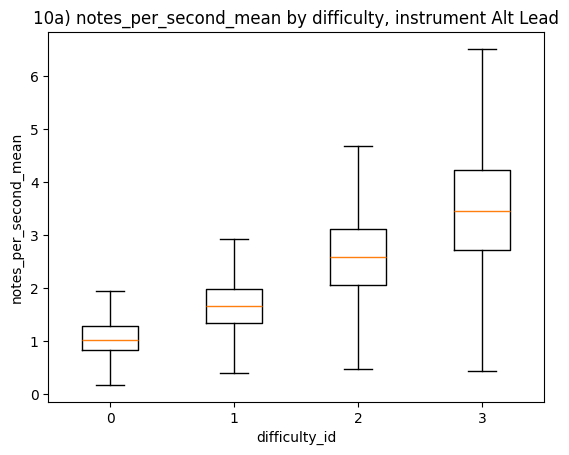

C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\3475120436.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


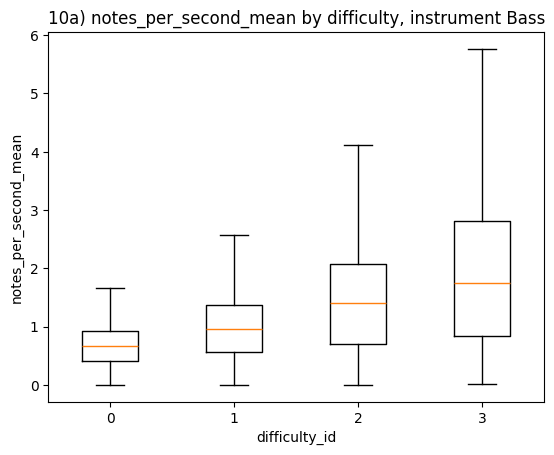

In [32]:
instrument_names = {0: "Rhythm", 1: "Lead", 2: "Alt Lead", 3: "Bass"}

feat = "notes_per_second_mean"
insts = sorted(df_features["instrument_id"].dropna().unique())

for inst in insts:
    sub = df_features[df_features["instrument_id"] == inst]
    diffs = sorted(sub["difficulty_id"].dropna().unique())
    groups = [sub.loc[sub["difficulty_id"] == d, feat].dropna() for d in diffs]

    plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)
    plt.xlabel("difficulty_id")
    plt.ylabel(feat)
    plt.title(f"10a) {feat} by difficulty, instrument {instrument_names.get(inst, str(inst))}")
    plt.show()


     feature  difficulty_id instrument_a instrument_b       ks  cliffs_delta_med  cliffs_delta_ci_low  cliffs_delta_ci_high  n_a  n_b
 chord_ratio              2       Rhythm         Lead 0.825463          0.881043             0.850146              0.909482 5841  372
 chord_ratio              2         Lead     Alt Lead 0.825029         -0.881006            -0.910580             -0.844767  372 5784
 chord_ratio              3         Lead     Alt Lead 0.796860         -0.848690            -0.880923             -0.812922  383 6037
 chord_ratio              3       Rhythm         Lead 0.795476          0.847572             0.812212              0.885236 6398  383
 chord_ratio              1       Rhythm         Lead 0.786548          0.843153             0.808321              0.868915 5837  374
 chord_ratio              1         Lead     Alt Lead 0.786521         -0.842177            -0.874222             -0.812119  374 5780
 chord_ratio              2         Lead         Bass 0.664014

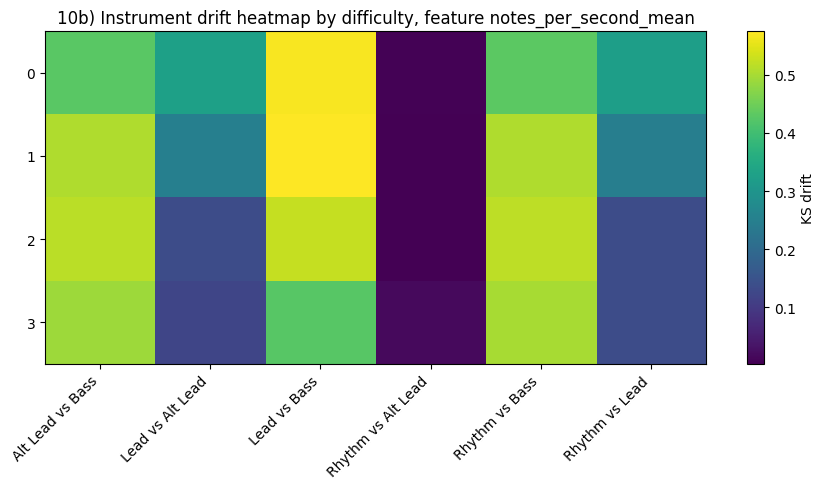

In [33]:
drift_feats = [
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "chord_ratio",
    "sustain_ratio",
    "hopo_ratio",
    "tap_ratio",
    "fret_entropy",
]

def ks_distance(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return np.nan
    a = np.sort(a); b = np.sort(b)
    x = np.sort(np.unique(np.concatenate([a, b])))
    cdf_a = np.searchsorted(a, x, side="right") / len(a)
    cdf_b = np.searchsorted(b, x, side="right") / len(b)
    return float(np.max(np.abs(cdf_a - cdf_b)))

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return np.nan
    a = a.reshape(-1, 1)
    diffs = a - b.reshape(1, -1)
    return float((np.sum(diffs > 0) - np.sum(diffs < 0)) / diffs.size)

def bootstrap_ci(func, a, b, n=400, seed=0):
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return (np.nan, np.nan, np.nan)
    vals = []
    for _ in range(n):
        aa = rng.choice(a, size=len(a), replace=True)
        bb = rng.choice(b, size=len(b), replace=True)
        vals.append(func(aa, bb))
    vals = np.asarray(vals)
    return (float(np.nanmedian(vals)),
            float(np.nanpercentile(vals, 2.5)),
            float(np.nanpercentile(vals, 97.5)))

rows = []
for feat in drift_feats:
    for d in sorted(df_features["difficulty_id"].dropna().unique()):
        sub = df_features[df_features["difficulty_id"] == d]
        insts = sorted(sub["instrument_id"].dropna().unique())
        for i in range(len(insts)):
            for j in range(i + 1, len(insts)):
                a = sub.loc[sub["instrument_id"] == insts[i], feat].dropna()
                b = sub.loc[sub["instrument_id"] == insts[j], feat].dropna()

                ks = ks_distance(a, b)
                cd_med, cd_lo, cd_hi = bootstrap_ci(cliffs_delta, a, b, n=400, seed=0)

                rows.append({
                    "feature": feat,
                    "difficulty_id": d,
                    "instrument_a": instrument_names.get(insts[i], str(insts[i])),
                    "instrument_b": instrument_names.get(insts[j], str(insts[j])),
                    "ks": ks,
                    "cliffs_delta_med": cd_med,
                    "cliffs_delta_ci_low": cd_lo,
                    "cliffs_delta_ci_high": cd_hi,
                    "n_a": len(a),
                    "n_b": len(b),
                })

drift = pd.DataFrame(rows)

print(
    drift.sort_values(["feature", "ks"], ascending=[True, False])
         .head(30)
         .to_string(index=False)
)

feat0 = "notes_per_second_mean"
tmp = drift[drift["feature"] == feat0].copy()
tmp["pair"] = tmp["instrument_a"] + " vs " + tmp["instrument_b"]
pivot = tmp.pivot_table(index="difficulty_id", columns="pair", values="ks", aggfunc="mean")

plt.figure(figsize=(9, 5))
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), [str(x) for x in pivot.index])
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.colorbar(label="KS drift")
plt.title(f"10b) Instrument drift heatmap by difficulty, feature {feat0}")
plt.tight_layout()
plt.show()

<h1>11. Feature Selection and Pruning Analysis</h1>

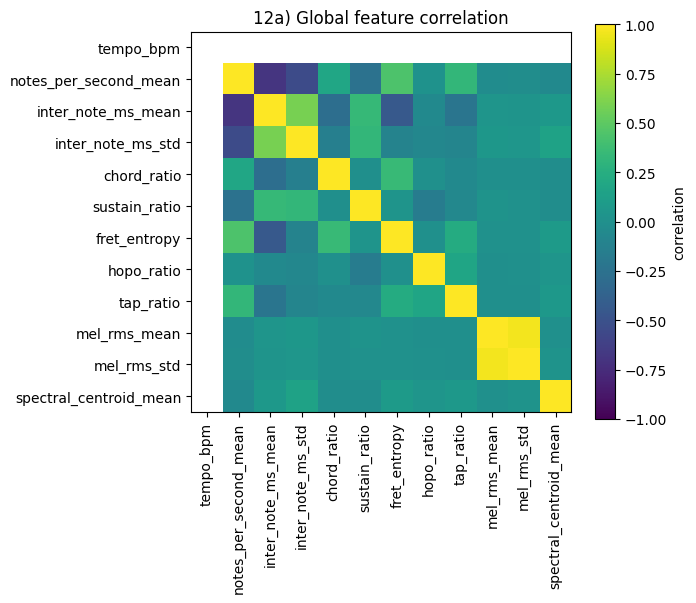

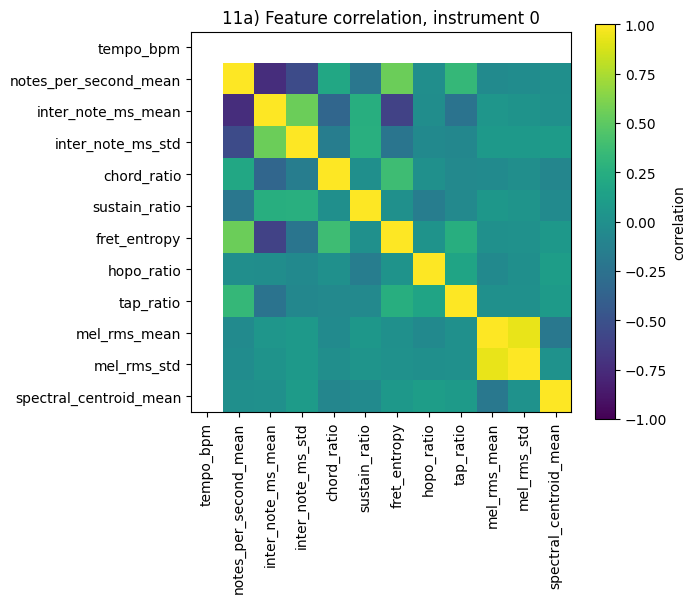

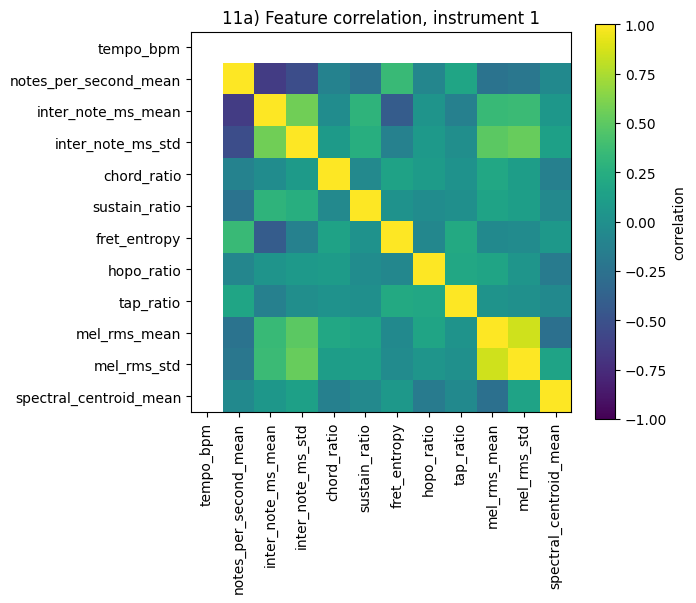

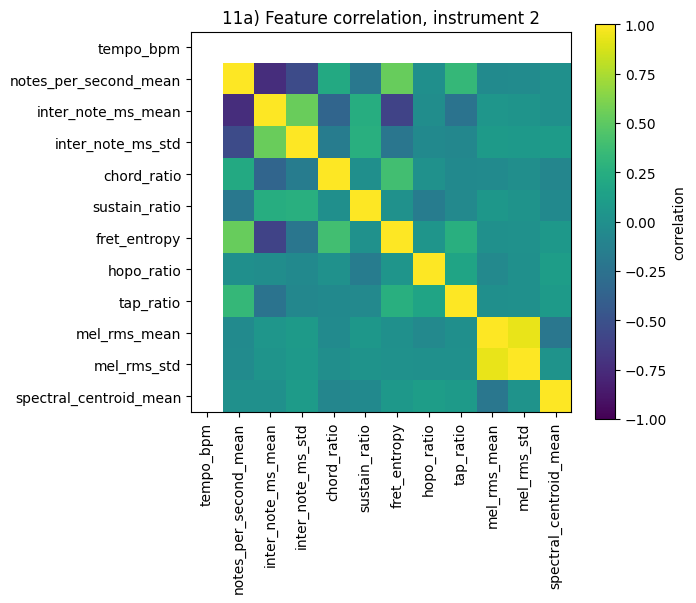

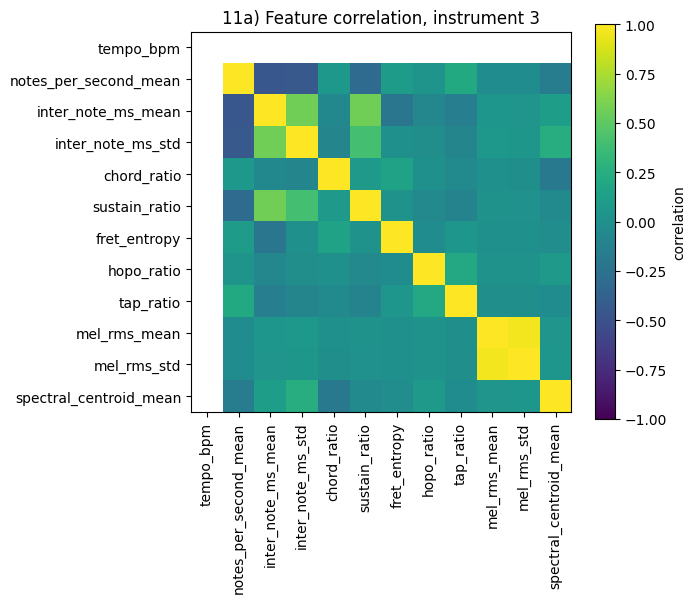

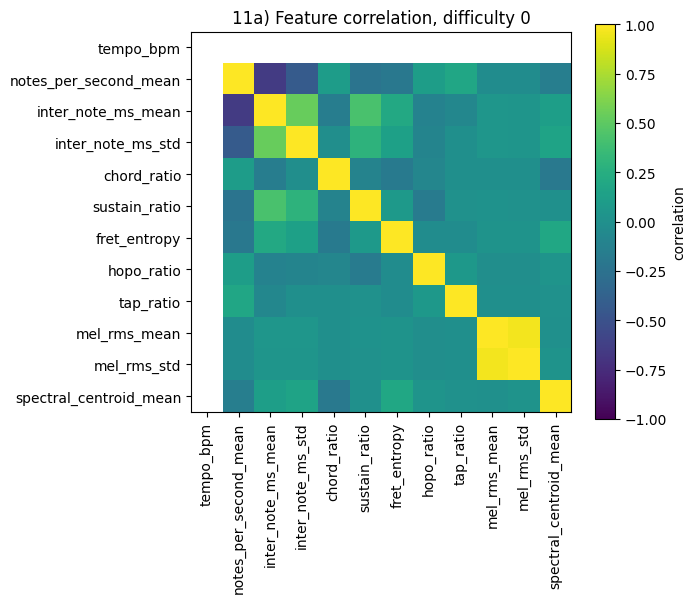

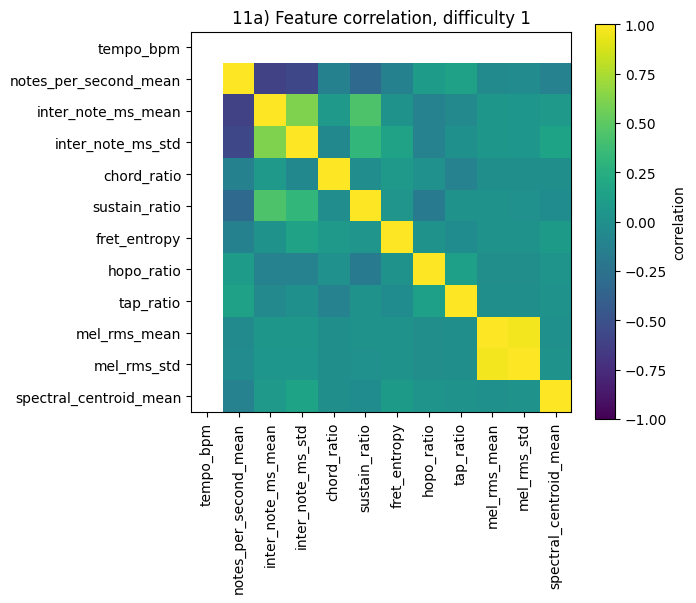

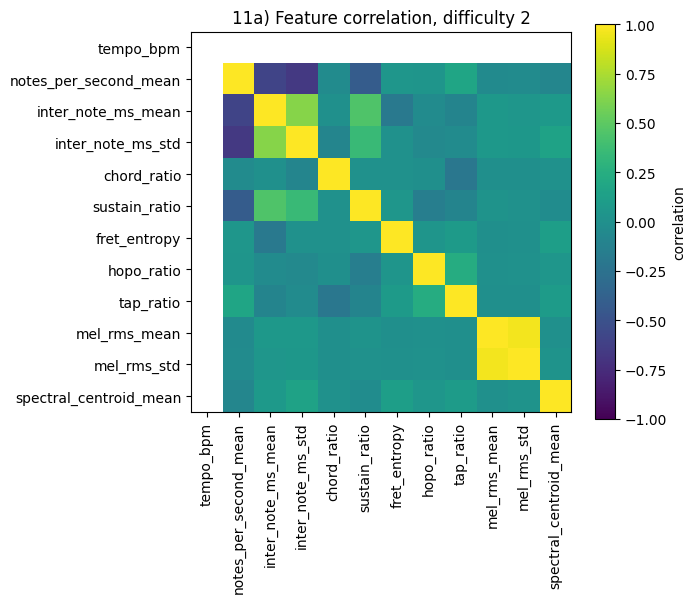

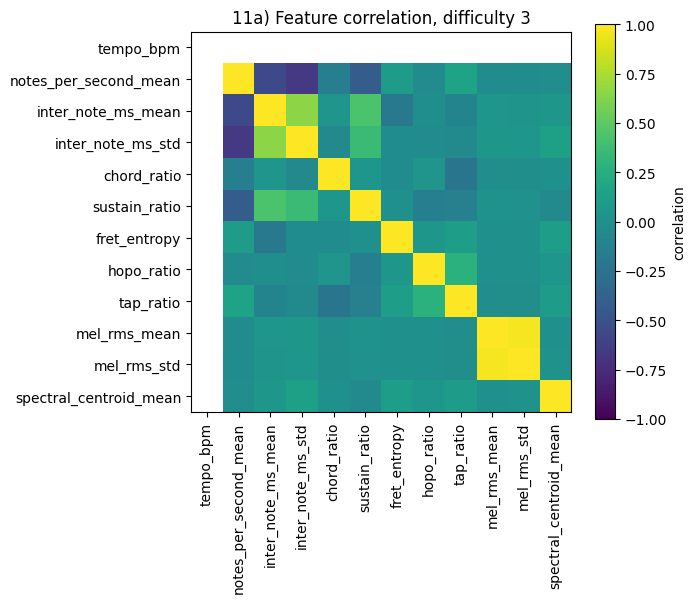

In [34]:

use_cols = [
    "tempo_bpm",
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "inter_note_ms_std",
    "chord_ratio",
    "sustain_ratio",
    "fret_entropy",
    "hopo_ratio",
    "tap_ratio",
    "mel_rms_mean",
    "mel_rms_std",
    "spectral_centroid_mean",
]

def plot_corr(df, title):
    C = df[use_cols].corr()
    plt.figure(figsize=(7, 6))
    plt.imshow(C, vmin=-1, vmax=1)
    plt.xticks(range(len(use_cols)), use_cols, rotation=90)
    plt.yticks(range(len(use_cols)), use_cols)
    plt.colorbar(label="correlation")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_corr(df_features, "11a) Global feature correlation")

for inst in sorted(df_features["instrument_id"].dropna().unique()):
    sub = df_features[df_features["instrument_id"] == inst]
    if len(sub) > 50:
        plot_corr(sub, f"11a) Feature correlation, instrument {inst}")

for d in sorted(df_features["difficulty_id"].dropna().unique()):
    sub = df_features[df_features["difficulty_id"] == d]
    if len(sub) > 50:
        plot_corr(sub, f"11a) Feature correlation, difficulty {d}")


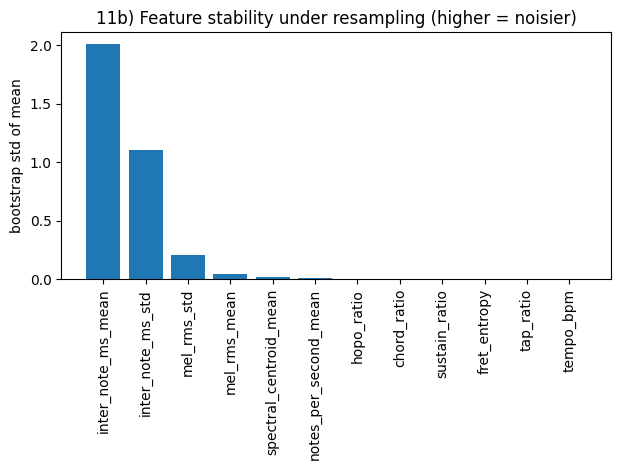

Bootstrap stability ranking (higher = less stable)
               feature  bootstrap_std
    inter_note_ms_mean       2.009748
     inter_note_ms_std       1.106334
           mel_rms_std       0.207440
          mel_rms_mean       0.039289
spectral_centroid_mean       0.021326
 notes_per_second_mean       0.007429
            hopo_ratio       0.001892
           chord_ratio       0.001535
         sustain_ratio       0.001239
          fret_entropy       0.001078
             tap_ratio       0.000359
             tempo_bpm       0.000000


In [35]:
def bootstrap_std(x, n=30, frac=0.8):
    rng = np.random.default_rng(0)
    vals = []
    for _ in range(n):
        idx = rng.choice(len(x), size=int(frac * len(x)), replace=True)
        vals.append(np.nanmean(x[idx]))
    return float(np.std(vals))

rows = []
for col in use_cols:
    x = df_features[col].dropna().values
    if len(x) < 200:
        continue
    rows.append({
        "feature": col,
        "bootstrap_std": bootstrap_std(x)
    })

stab = (
    pd.DataFrame(rows)
    .sort_values("bootstrap_std", ascending=False)
)

plt.bar(stab["feature"], stab["bootstrap_std"])
plt.xticks(rotation=90)
plt.ylabel("bootstrap std of mean")
plt.title("11b) Feature stability under resampling (higher = noisier)")
plt.tight_layout()
plt.show()

print("Bootstrap stability ranking (higher = less stable)")
print(stab.to_string(index=False))


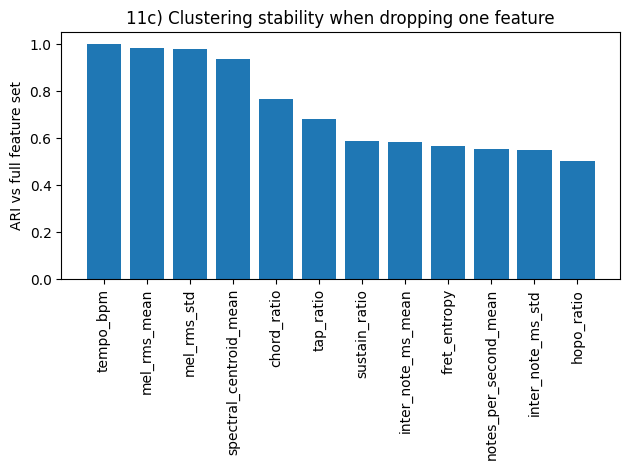

Leave-one-out clustering impact (higher ARI = less important feature)
       feature_dropped  ARI_vs_full
             tempo_bpm     1.000000
          mel_rms_mean     0.982967
           mel_rms_std     0.977082
spectral_centroid_mean     0.937178
           chord_ratio     0.766153
             tap_ratio     0.682140
         sustain_ratio     0.589181
    inter_note_ms_mean     0.584745
          fret_entropy     0.564904
 notes_per_second_mean     0.551615
     inter_note_ms_std     0.550132
            hopo_ratio     0.500688


In [36]:

def cluster_labels(cols):
    X = df_features[cols].replace([np.inf, -np.inf], np.nan).dropna()
    scaled = StandardScaler().fit_transform(X.values)
    return KMeans(n_clusters=8, random_state=0, n_init=10).fit_predict(scaled)

base_labels = cluster_labels(use_cols)

impact = []
for col in use_cols:
    reduced = [c for c in use_cols if c != col]
    labels = cluster_labels(reduced)
    ari = adjusted_rand_score(base_labels, labels)
    impact.append({
        "feature_dropped": col,
        "ARI_vs_full": ari
    })

impact_df = (
    pd.DataFrame(impact)
    .sort_values("ARI_vs_full", ascending=False)
)

plt.bar(impact_df["feature_dropped"], impact_df["ARI_vs_full"])
plt.xticks(rotation=90)
plt.ylabel("ARI vs full feature set")
plt.title("11c) Clustering stability when dropping one feature")
plt.tight_layout()
plt.show()

print("Leave-one-out clustering impact (higher ARI = less important feature)")
print(impact_df.to_string(index=False))


C:\Users\Susan\AppData\Local\Temp\ipykernel_3640\287975543.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = spearmanr(sub["difficulty_id"], sub[col])


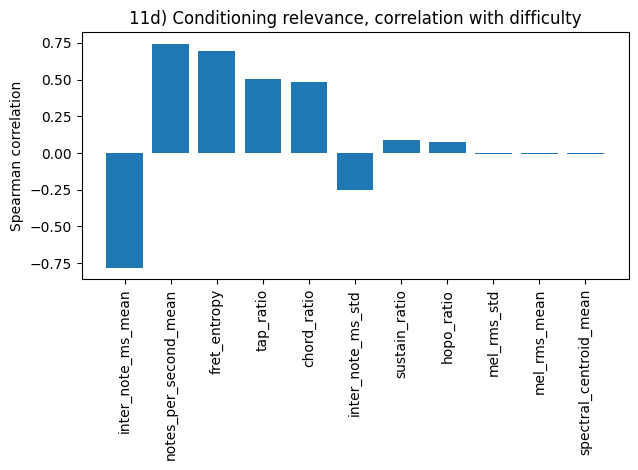

Conditioning relevance ranking
               feature  spearman_vs_difficulty  abs_corr
    inter_note_ms_mean               -0.781675  0.781675
 notes_per_second_mean                0.745203  0.745203
          fret_entropy                0.697761  0.697761
             tap_ratio                0.506403  0.506403
           chord_ratio                0.483076  0.483076
     inter_note_ms_std               -0.253697  0.253697
         sustain_ratio                0.086214  0.086214
            hopo_ratio                0.072779  0.072779
           mel_rms_std               -0.006034  0.006034
          mel_rms_mean               -0.005936  0.005936
spectral_centroid_mean               -0.003955  0.003955
             tempo_bpm                     NaN       NaN


In [37]:
rows = []
for col in use_cols:
    sub = df_features[["difficulty_id", col]].dropna()
    if len(sub) < 200:
        continue
    r, _ = spearmanr(sub["difficulty_id"], sub[col])
    rows.append({
        "feature": col,
        "spearman_vs_difficulty": r
    })

rel = (
    pd.DataFrame(rows)
    .assign(abs_corr=lambda d: d["spearman_vs_difficulty"].abs())
    .sort_values("abs_corr", ascending=False)
)

plt.bar(rel["feature"], rel["spearman_vs_difficulty"])
plt.xticks(rotation=90)
plt.ylabel("Spearman correlation")
plt.title("11d) Conditioning relevance, correlation with difficulty")
plt.tight_layout()
plt.show()

print("Conditioning relevance ranking")
print(rel.to_string(index=False))
